<a href="https://colab.research.google.com/github/Cralsic123/Classifier-Based-Evaluation-of-Image-Feature-Importance/blob/main/Classifier_Based_Evaluation_of_Image_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [4]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy import ndimage
grad_cam = imageio.imread('/content/Kitten/Grad-CAM.png')  # Assuming Grad-CAM.png is the filename of your Grad-CAM image
kitten = imageio.imread('/content/Kitten/kitten.jpeg')  # Assuming Kitten.jpeg is the filename of your ground truth image

gt_height, gt_width, _ = kitten.shape
cam_height, cam_width, _ = grad_cam.shape

scale_height = gt_height / cam_height
scale_width = gt_width / cam_width

zoomed_cam = ndimage.zoom(grad_cam, (scale_height, scale_width, 1))


<ipython-input-4-faf5cb933e06>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grad_cam = imageio.imread('/content/Kitten/Grad-CAM.png')  # Assuming Grad-CAM.png is the filename of your Grad-CAM image
<ipython-input-4-faf5cb933e06>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kitten = imageio.imread('/content/Kitten/kitten.jpeg')  # Assuming Kitten.jpeg is the filename of your ground truth image


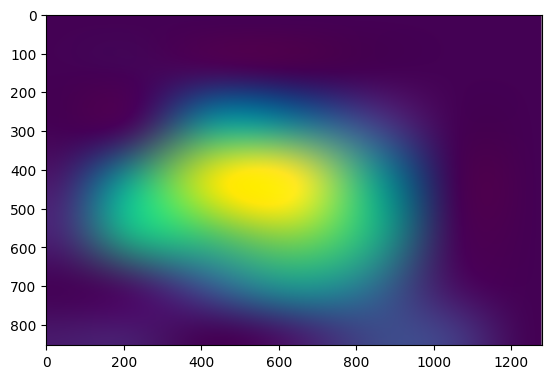

In [5]:
plt.imshow(zoomed_cam)
plt.show()

In [6]:
imageio.imsave('Zoomed_Grad_CAM.png', zoomed_cam)

In [7]:
import os
def Zoom(img_path):
  grad_cam = imageio.imread(img_path)  # Assuming Grad-CAM.png is the filename of your Grad-CAM image
  kitten = imageio.imread('/content/Kitten/kitten.jpeg')  # Assuming Kitten.jpeg is the filename of your ground truth image

  gt_height, gt_width, _ = kitten.shape
  cam_height, cam_width, _ = grad_cam.shape

  scale_height = gt_height / cam_height
  scale_width = gt_width / cam_width

  zoomed_cam = ndimage.zoom(grad_cam, (scale_height, scale_width, 1))
  name = "Zoomed_" + os.path.basename(img_path)
  imageio.imsave(name, zoomed_cam)

In [8]:
Zoom("/content/Kitten/Faster-Score-CAM.png")
Zoom("/content/Kitten/Grad-CAM++.png")
Zoom("/content/Kitten/LIME1.png")
Zoom("/content/Kitten/Score-CAM.png")
Zoom("/content/Kitten/Segmentation1.png")
Zoom("/content/Kitten/Superimposed.png")

<ipython-input-7-45e2f2ef43af>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grad_cam = imageio.imread(img_path)  # Assuming Grad-CAM.png is the filename of your Grad-CAM image
<ipython-input-7-45e2f2ef43af>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kitten = imageio.imread('/content/Kitten/kitten.jpeg')  # Assuming Kitten.jpeg is the filename of your ground truth image


In [9]:
original_image = cv2.imread('/content/Kitten/kitten.jpeg')
explanation_heatmaps = [
    cv2.imread('Zoomed_Superimposed.png'),
    cv2.imread('Zoomed_Segmentation1.png'),
    cv2.imread('Zoomed_Score-CAM.png'),
    cv2.imread('Zoomed_LIME1.png'),
    cv2.imread('Zoomed_Faster-Score-CAM.png'),
    cv2.imread('Zoomed_Grad-CAM++.png'),
    cv2.imread('Zoomed_Grad_CAM.png')
]

Trying to use thresholding to segment the ROI based on brightness

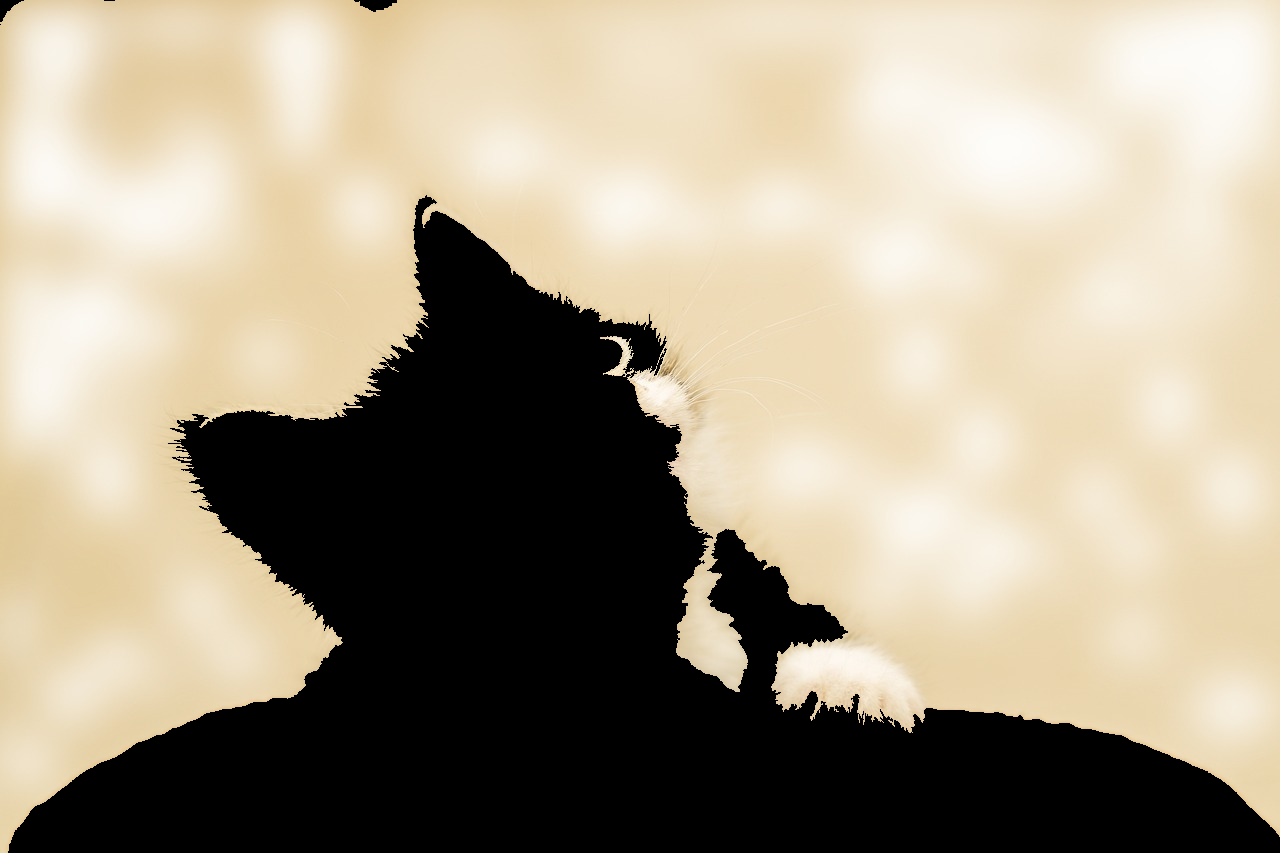

In [10]:
from google.colab.patches import cv2_imshow

copy=original_image
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
_, binary_threshold = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(binary_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key=cv2.contourArea)

roi_mask = np.zeros_like(gray_image)
cv2.drawContours(roi_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

segmented_roi = cv2.bitwise_and(original_image, original_image, mask=roi_mask)

cv2_imshow(segmented_roi)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [11]:
original_roi = cv2.cvtColor(segmented_roi, cv2.COLOR_BGR2GRAY)

In [12]:
def compute_mse(image1, image2):
    return mean_squared_error(image1.flatten(), image2.flatten())

def compute_ssim(image1, image2):
    return ssim(image1, image2)

def compute_iou(image1, image2):
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def compute_pixel_accuracy(image1, image2):
    return accuracy_score(image1.flatten(), image2.flatten())

# Compute metrics for each explanation heatmap
for heatmap in explanation_heatmaps:
    heatmap_gray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

    mse = compute_mse(original_roi, heatmap_gray)
    ssim_score = compute_ssim(original_roi, heatmap_gray)
    iou = compute_iou(original_roi, heatmap_gray)
    accuracy = compute_pixel_accuracy(original_roi, heatmap_gray)

    print("Metrics for heatmap:")
    print("MSE:", mse)
    print("SSIM:", ssim_score)
    print("IoU:", iou)
    print("Pixel Accuracy:", accuracy)
    print()

Metrics for heatmap:
MSE: 96.31249816822978
SSIM: 0.4260970403249537
IoU: 0.6952557151230949
Pixel Accuracy: 9.158851113716295e-07

Metrics for heatmap:
MSE: 83.17428652549825
SSIM: 0.1442072642998195
IoU: 0.0354640905926024
Pixel Accuracy: 0.1423679293669402

Metrics for heatmap:
MSE: 106.5212631887456
SSIM: 0.3442743875165855
IoU: 0.6944992965899266
Pixel Accuracy: 1.4654161781946073e-05

Metrics for heatmap:
MSE: 110.28053744138336
SSIM: 0.3478408224832346
IoU: 0.6952557151230949
Pixel Accuracy: 9.158851113716295e-07

Metrics for heatmap:
MSE: 108.44203821072685
SSIM: 0.2981934206280633
IoU: 0.6944992965899266
Pixel Accuracy: 1.831770222743259e-05

Metrics for heatmap:
MSE: 107.68776469079718
SSIM: 0.32493980963754643
IoU: 0.6944992965899266
Pixel Accuracy: 2.1981242672919108e-05

Metrics for heatmap:
MSE: 108.93106315943729
SSIM: 0.2762635402323947
IoU: 0.6944992965899266
Pixel Accuracy: 7.052315357561547e-05



I would implement SCG here where I will try to find the probabilities of these images to be closer to be detected as the original image

Adding a blur mask on the image of grad cam


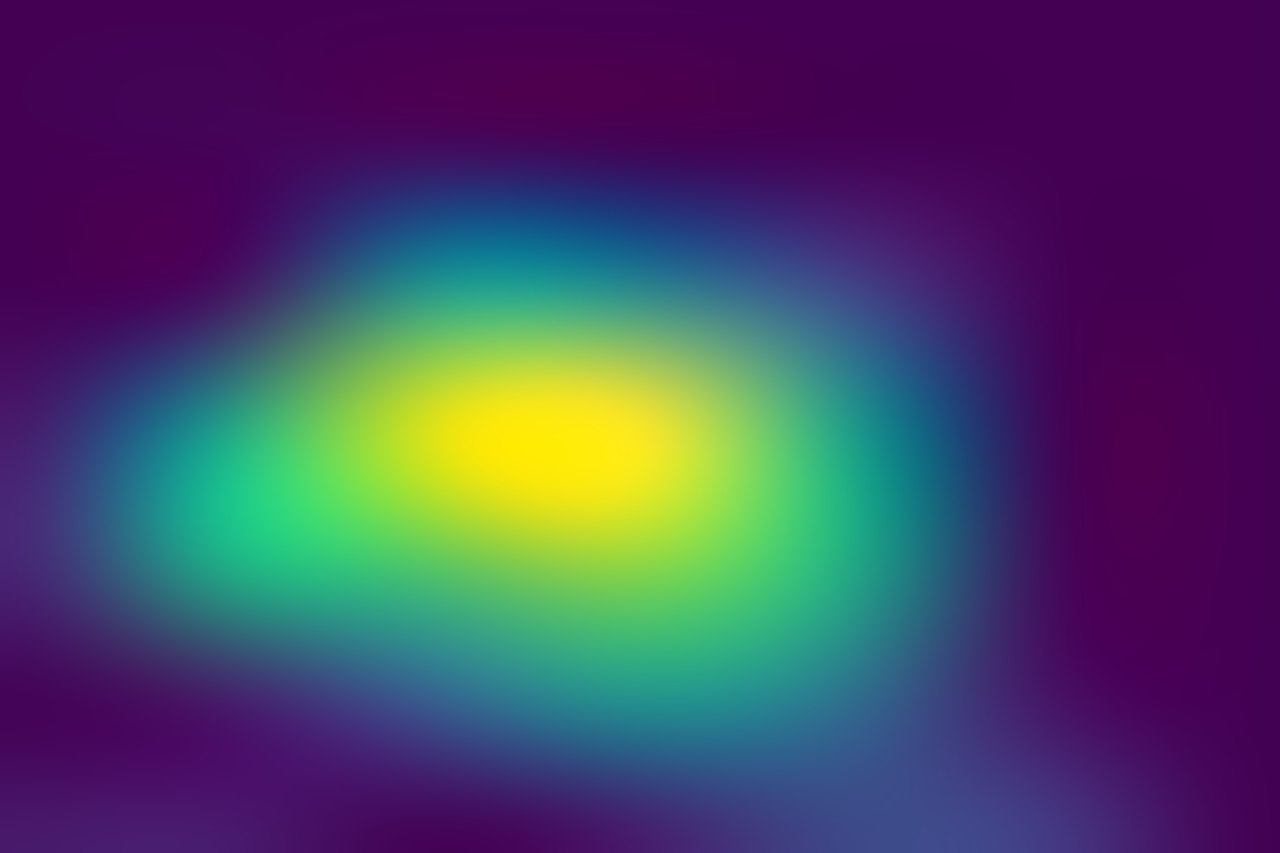

True

In [20]:
import cv2
from google.colab.patches import cv2_imshow

gradcam_image = cv2.imread('/content/Zoomed_Grad_CAM.png')
blurred_image = cv2.GaussianBlur(gradcam_image, (101, 101), 0)  # Adjust the kernel size as needed

cv2_imshow( blurred_image)

cv2.imwrite('blurred_gradcam_image.png', blurred_image)